# Neural networks as probability models

* [xkcd dataset](#xkcd-dataset)
** [Least squares regression](#Least-squares-regression)
** [Gaussian regression](#Gaussian-regression)
* [Classification (MNIST dataset)](#Classification-(MNIST-dataset))
** [Simple classifier](#Simple-classifier)
* [Generation with RNN (dataset of English names)](#Generation-with-RNN-(dataset-of-English-names))

In [1]:
import numpy as np
import pandas
import matplotlib.pyplot as plt
import matplotlib
import torch
import torch.optim as optim
import torch.nn as nn
import torchvision
import IPython

In [2]:
# Utility to streamline interactive start-and-stop optimization.
# See the examples below for its use.

import signal
class Interruptable():
    class Breakout(Exception):
        pass
    def __init__(self):
        self.interrupted = False
        self.orig_handler = None
    def __enter__(self):
        self.orig_handler = signal.getsignal(signal.SIGINT)
        signal.signal(signal.SIGINT, self.handle)
        return self.check
    def __exit__(self, exc_type, exc_val, exc_tb):
        signal.signal(signal.SIGINT, self.orig_handler)
        if exc_type == Interruptable.Breakout:
            print(' stopped')
            return True
        return False
    def handle(self, signal, frame):
        if self.interrupted:
            self.orig_handler(signal, frame)
        print('Interrupting ...', end='')
        self.interrupted = True
    def check(self):
        if self.interrupted:
            raise Interruptable.Breakout

# xkcd dataset

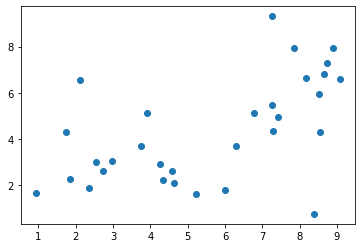

In [3]:
# The data behind https://xkcd.com/2048/
url = 'https://www.cl.cam.ac.uk/teaching/2122/DataSci/data/xkcd.csv'
xkcd = pandas.read_csv(url)
plt.scatter(xkcd.x, xkcd.y)
plt.show()

## Least squares regression

In [4]:
# This defines an arbitrary messy function that (we hope) can approximate the data reasonably well.
# The neural network layers (nn.Linear) all have their own parameters, which need to be optimized.

class Wiggle(nn.Module):
    def __init__(self):
        super().__init__()
        self.f = nn.Sequential(
            nn.Linear(1,4),
            nn.LeakyReLU(),
            nn.Linear(4,20),
            nn.LeakyReLU(),
            nn.Linear(20,20),
            nn.LeakyReLU(),
            nn.Linear(20,1)
        )
    def forward(self, x):
        return self.f(x)

In [5]:
x,y = torch.tensor(xkcd.x, dtype=torch.float)[:,None], torch.tensor(xkcd.y, dtype=torch.float)[:,None]

myline = Wiggle()
epoch = 0

epoch=15200 loss=1.757


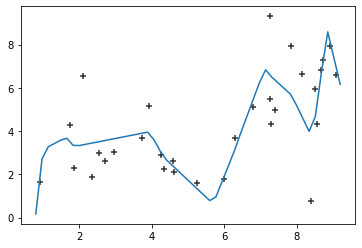

Interrupting ... stopped


In [6]:
optimizer = optim.Adam(myline.parameters())

with Interruptable() as check_interrupted:
    while True:
        check_interrupted()
        optimizer.zero_grad()
        loss = torch.mean(torch.pow(y - myline(x), 2))
        loss.backward()
        optimizer.step()
        epoch += 1

        if epoch % 200 == 0:
            IPython.display.clear_output(wait=True)
            plt.scatter(x, y, color='black', marker='+', alpha=.8)
            with torch.no_grad():
                xnew = torch.linspace(.8,9.2,50)[:,None]
                plt.plot(xnew, myline.f(xnew))
            print(f'epoch={epoch} loss={loss.item():.4}')
            plt.show()

To save the model parameters to a file, and to load them:
```
torch.save(model.state_dict(), 'models/wiggle.pt')

myline = Wiggle()
myline.load_state_dict(torch.load('models/wiggle.pt'))
```

## Gaussian regression

In [7]:
# This model uses the wiggly line class Wiggle defined above

class RWiggle(nn.Module):
    def __init__(self):
        super().__init__()
        self.μ = Wiggle()
        self.σ = nn.Parameter(torch.tensor(1.0))
    def forward(self, y, x):
        σ2 = torch.pow(self.σ, 2)
        return - 0.5*torch.log(2*np.pi*σ2) - torch.pow(y - self.μ(x), 2) / (2*σ2)

In [8]:
def plot_loglik(rwiggle,ax):
    G = 100
    mx,Mx,my,My = 0,10,0,10
    xx,yy = np.meshgrid(np.linspace(mx,Mx,G), np.linspace(my,My,G))
    xx,yy = torch.tensor(xx, dtype=torch.float).reshape(-1,1), torch.tensor(yy, dtype=torch.float).reshape(-1,1)
    with torch.no_grad():
        p = torch.exp(rwiggle(yy,xx)).detach().numpy()
    pp = p.reshape(G,G)

    b = plt.get_cmap('Blues')
    cols = np.row_stack([[[1,1,1,1]], b(np.linspace(0,1,9))])
    cols = [[1,1,1,1], b(.2), b(.4), b(.6), b(.7), b(.8), b(.9)]
    bluesw = matplotlib.colors.LinearSegmentedColormap.from_list('BluesW', cols)  
    
    ax.imshow(pp, extent=(mx,Mx,my,My), origin='lower', cmap=bluesw, alpha=.4)
    
    with torch.no_grad():
        xnew = torch.linspace(.8,9.2,50)[:,None]
        ax.plot(xnew, rwiggle.μ(xnew), color='steelblue')

In [9]:
x,y = torch.tensor(xkcd.x, dtype=torch.float)[:,None], torch.tensor(xkcd.y, dtype=torch.float)[:,None]

rwiggle = RWiggle()
rwiggle.μ.load_state_dict(myline.state_dict()) # copy the parameters for μ from what we trained with least squares
epoch = 0

epoch=11400 loglik=-1.499 σ=1.084


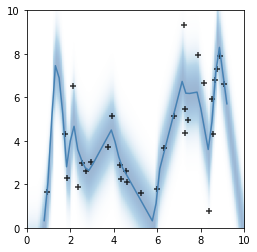

Interrupting ... stopped


In [10]:
optimizer = optim.Adam(rwiggle.parameters())

with Interruptable() as check_interrupted:
    while True:
        check_interrupted()
        optimizer.zero_grad()
        loglik = torch.mean(rwiggle(y, x))
        (-loglik).backward()
        optimizer.step()
        epoch += 1

        if epoch % 200 == 0:
            IPython.display.clear_output(wait=True)
            plt.scatter(x, y, color='black', marker='+', alpha=.8)
            plot_loglik(rwiggle, plt.gca())
            print(f'epoch={epoch} loglik={loglik.item():.4} σ={rwiggle.σ.item():.4}')
            plt.show()

# Classification (MNIST dataset)

In [12]:
# PyTorch comes with a simple wrapper around the MNIST dataset.
# The dataset consists of a pair of (numpy_array, int) representing images and labels.
# We can pull out (image,label) pairs using e.g.
#   img,lbl = mnist[0]
#   img,lbl = next(iter(mnist))

mnist = torchvision.datasets.MNIST(
    root = 'pytorch-data/',    # where to put the files
    download = True,   # if files aren't here, download them
    train = True,      # whether to import the test or the train subset
    # PyTorch uses PyTorch tensors internally, not numpy arrays, so convert them.
    transform = torchvision.transforms.ToTensor()
)


# Very many PyTorch building blocks assume that the data comes in batches.
# The DataLoader converts the full mnist list [(img,lbl),...] into batches
#     [(img_batch,lbl_batch), ...]
# where each img_batch is an array with an extra dimension prepended.

mnist_batched = torch.utils.data.DataLoader(mnist, batch_size=5)

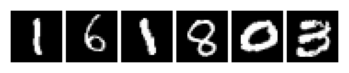

[4950, 33794, 2040, 54612, 38157, 49157]

In [13]:
# Look at a few sample images

import collections
img_i = collections.defaultdict(list)
for i,(_,k) in enumerate(mnist):
    img_i[k].append(i)
    
rng = np.random.default_rng()
show_i = [rng.choice(img_i[k]) for k in [1,6,1,8,0,3]]
show = torch.stack([mnist[i][0] for i in show_i])
x = torchvision.utils.make_grid(show, nrow=6, pad_value=1)
plt.imshow(x.numpy().transpose((1,2,0)))
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()
show_i

In [14]:
# When I'm training a neural network, it's nice to be able to interrupt training,
# inspect, tweak, and resume training. This function enumerate_cycle defines a
# Python generator which cycles through a dataset over and over again,
# and because it's a generator it can store which epoch it's on. Thus, when you 
# interrupt and resume, you don't need to store an extra state variable "which epoch
# am I on".

def enumerate_cycle(g, shuffle=True):
    epoch = 0
    while True:
        if shuffle:
            for i,j in enumerate(np.random.permutation(len(g))):
                yield (epoch,i), g[j]
        else:
            for i,x in enumerate(g):
                yield (epoch,i), x
        epoch = epoch + 1

## Simple classifier

In [15]:
class ImageClassifier1(nn.Module):
    def __init__(self):
        super().__init__()
        self.f = nn.Sequential(       # input shape [B*1*28*28]
            nn.Conv2d(1, 32, 3, 1),   # -> [B*32*26*26]
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, 1),  # -> [B*64*24*24]
            nn.MaxPool2d(2),          # -> [B*64*12*12]
            nn.Dropout2d(0.25),
            nn.Flatten(1),            # -> [B*9216]
            nn.Linear(9216, 128),     # -> [B*128]
            nn.ReLU(),
            nn.Dropout2d(0.5),
            nn.Linear(128, 10)        # -> [B*10]
        )

    # compute log likelihood for a batch of data
    def forward(self, x, y):          # x.shape [B*1*28*28], y.shape [B], output.shape [B]
        return - nn.functional.cross_entropy(self.f(x), y, reduction='none')

    # compute the class probabilities for a single image
    def classify(self, x):  # input: [1*28*28] array
        q = self.f(torch.as_tensor(x)[None,...])[0]
        return nn.functional.softmax(q, dim=0)

In [16]:
model = ImageClassifier1()
epoch = 0

In [17]:
model.train(mode=True) # put it into training mode (turns dropout on)
optimizer = optim.Adam(model.parameters())

with Interruptable() as check_interrupted:
    for batch_num, (imgs,lbls) in enumerate(mnist_batched):
        check_interrupted()
        optimizer.zero_grad()
        loglik = model(imgs, lbls)
        e = - torch.mean(loglik)
        e.backward()
        optimizer.step()

        if batch_num % 25 == 0:
            IPython.display.clear_output(wait=True)
            print(f'epoch={epoch} batch={batch_num}/{len(mnist_batched)} loglik={-e.item()}')
    epoch += 1

epoch=0 batch=1125/12000 loglik=-0.14967447519302368
Interrupting ... stopped


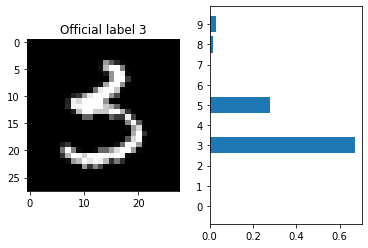

In [18]:
model.train(mode=False)  # put it into execution mode (turns dropout off)
img,lbl = mnist[14028]
p = model.classify(img).detach().numpy()

fig,(ax1,ax2) = plt.subplots(1,2)
ax1.imshow(img[0], cmap='gray')
ax2.barh(np.arange(10), p)
ax2.set_yticks(np.arange(10))
ax1.set_title(f'Official label {lbl}')
plt.show()

# Generation with RNN (dataset of English names)

In [22]:
url = "https://www.cl.cam.ac.uk/teaching/2122/DataSci/data/english_names.txt"
names = pandas.read_table(url, header=None, names=['X']).X.str.lower()

names.sample(5)

2420    norbury
90      althoff
3169       tarr
2671       pike
657      denney
Name: X, dtype: object

In [40]:
# The neural network recurrent unit (called f_θ in lecture notes) takes in a character
# and a hidden state. In order for a neural network to accept a character, the character
# has to be encoded into a number or vector. Here we're creating one-hot coded versions
# of the names: each item in names_oh is an array with shape (name_len × alphabet_len),
#
#      names_oh[i][l,a] = Indicator[name i has character a in position l]

alphabet = list(set(''.join(names)))
alphabet_n = {c:i+1 for i,c in enumerate(alphabet)}
A = len(alphabet)+1

names_n = [[0] + [alphabet_n[x] for x in name] + [0] for name in names]
names_n = [torch.tensor(n) for n in names_n]
names_oh = [nn.functional.one_hot(n, num_classes=A).float() for n in names_n]

names_oh,names_oh_holdout = names_oh[:3000], names_oh[3000:]

In [41]:
# A simple model for a random character sequence.
# See printed lecture notes for an explanation.

class RSeq(nn.Module):
    def __init__(self, H=50, L=2):
        super().__init__()
        self.rnn = nn.GRU(input_size=A, hidden_size=H, num_layers=L, dropout=.05)
        self.map = nn.Linear(self.rnn.hidden_size, A)
    
    def f(self, x, v=None):  # x.shape=m*b*A, v.shape=L*b*H
        assert x.shape[1]==1, "This code only works with batch_size=1"
        y,v = self.rnn(x, v) # y.shape=m*b*H, v.shape=L*b*H
        z = self.map(y)      # z.shape=m*b*A
        logp = nn.functional.log_softmax(z, dim=2) # logp.shape=m*b*A
        return v,logp
    
    def forward(self, x): # x.shape = (n+1)*b*A
        _,logp = self.f(x[:-1])      # logp.shape = n*b*A
        return torch.sum(logp * x[1:], dim=(0,2)) # shape = b
    
    def generate(self):
        is_training = self.training
        self.train(False)
        with torch.no_grad():
            res = ''
            x_n,v = 0,None
            while True:
                x_n = torch.tensor(x_n).reshape(1,1)
                x_oh = nn.functional.one_hot(x_n, num_classes=A).float()
                v,logp = model.f(x_oh, v)
                p = torch.exp(logp[0,0])
                x_n = np.random.choice(A, p=p.detach().numpy())
                if x_n == 0: break
                res += alphabet[x_n-1]
        self.train(is_training)
        return res

In [34]:
model = RSeq()
model.train(True)
optimizer = optim.Adam(model.parameters())
ei_names = enumerate_cycle(np.random.permutation(len(names_oh)))
loss_history = []

In [44]:
with Interruptable() as check_interrupted:
    for (epoch,i),j in ei_names:
        check_interrupted()
        optimizer.zero_grad()
        loglik = model(names_oh[j][:,None,:])
        (-loglik).backward()
        optimizer.step()

        if i % 20 == 0:
            IPython.display.clear_output(wait=True)
            with torch.no_grad():
                eval_loglik = np.mean([model(n[:,None,:]).item() for n in names_oh_holdout])
            print(f'epoch={epoch} item={i}/{len(names_oh)} loglik.e={eval_loglik:.4} loglik({names[j]})={loglik.item():.4} name={model.generate()}')
            loss_history.append((epoch+i/len(names_oh), loglik.item(), eval_loglik))

epoch=4 item=1040/3000 loglik.e=-20.28 loglik(mackay)=-13.02 name=polb
Interrupting ... stopped


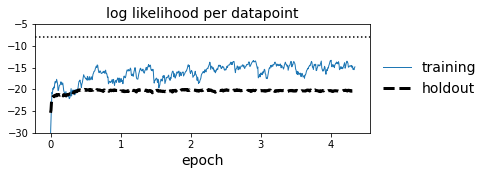

In [45]:
# Simple plot of the training loss

df = pandas.DataFrame.from_records(loss_history, columns=['epoch','loglik_tr','loglik_eval'])
fig,ax = plt.subplots(figsize=(6,2))
ax.plot(df.epoch, df.loglik_tr.ewm(com=8).mean(), linewidth=1, label='training') # ewm computes moving average
ax.plot(df.epoch, df.loglik_eval, linewidth=3, linestyle='dashed', color='black', label='holdout')
ax.axhline(y=np.log(1/len(names_oh)), color='black', linestyle=':')

ax.set_ylim([-30,-5])
ax.set_title('log likelihood per datapoint', fontsize=14)
ax.set_xlabel('epoch', fontsize=14)
plt.legend(bbox_to_anchor=(1,.5), loc='center left', frameon=False, fontsize=14)
plt.show()